In [1]:
%matplotlib inline

import aplpy
import matplotlib.pyplot as plt
from astropy.io import fits
import astropy.units as u
from NOEMAsetup import *
from spectral_cube import SpectralCube
from ChauvenetRMS import *
from astropy.coordinates import SkyCoord

### H2CO integrated moment plot

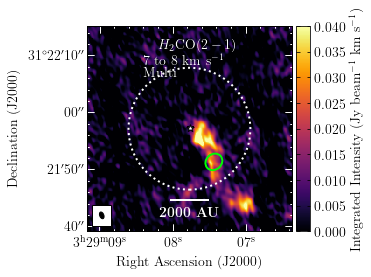

In [3]:
saveaction = 1
contourplot = 0
regionplot = 1

folder = 'H2CO/CDconfig/'
filename = H2CO_303_202
cleanalg = 'Multi'
stretch = 'linear'
moment = 0
velinit = 7 #km/s
velend = 8 #km/s
savefile = folder + 'H2CO_'+cleanalg+'_'+str(velinit)+'to'+str(velend)+'_'+stretch+'_moment'+str(moment)+'_SMAbeam.pdf'
vmin = 0
vmax = 0.04
vmid = 0.01
cmap = 'inferno'
radiusplot = 18/3600
title = r'$H_{2}$CO($2-1$)\\'+str(velinit)+' to '+str(velend)+r' km s$^{-1}$\\'+cleanalg
# title = r'\textbf{\boldmath H$_{2}$CO($3_{0,3}-2_{0,2}$), NOEMA}'

contourfile = 'SO_55_44/Per-emb-50_C_l009l048_cont.fits'
contourfile2 = filename+'.fits'
contlevels = [0.007]
regions = folder +'beam_COM_SMA.reg'
# regions2 = folder +'spectra_aux_reg2.reg'

cube = SpectralCube.read(filename+'.fits')
cube = cube.with_spectral_unit(u.km/u.s)
headercube = cube.hdu.header
freq = headercube['RESTFREQ'] * u.Hz
# If not noema data
# pbdata = 48.0 * u.arcsec * 230.e9*u.Hz / freq

phasecent = [headercube['ra'], headercube['dec']]
# phasecent = [ra_Per50, dec_Per50]


subcube = cube.spectral_slab(velinit*u.km/u.s, velend*u.km/u.s)
moment0 = subcube.moment(order=moment).hdu
rms = calculatenoise(moment0.data)[0]
if contourplot:
    contourfile = SpectralCube.read(contourfile)
    contourfile = contourfile[0,:,:]
    contourfile2 = SpectralCube.read(contourfile2).with_spectral_unit(u.km/u.s)
    contour2 = contourfile2.spectral_slab(velinit*u.km/u.s, velend*u.km/u.s).moment(order=moment).hdu
    rms2 = calculatenoise(contour2.data)[0]


fig = aplpy.FITSFigure(moment0, figsize=(4,4))
if stretch=='arcsinh':
    fig.show_colorscale(stretch=stretch, cmap=cmap, vmin=vmin, vmax=vmax, vmid=vmid)
else:
    fig.show_colorscale(stretch=stretch, cmap=cmap, vmin=vmin, vmax=vmax)
fig.add_colorbar()
fig.colorbar.set_axis_label_text(r'Integrated Intensity (Jy beam$^{-1}$ km s$^{-1}$)')
# fig.colorbar.set_axis_label_font(size=20)
# fig.colorbar.set_font(size=20)
setup_plot_noema(fig, label_col='w', star_col='k')
fig.show_circles(phasecent[0], phasecent[1], (pb_noema(freq).to(u.deg)*0.5).value, ls=':', color='w', lw=2)
# fig.show_circles(phasecent[0], phasecent[1], (pbdata).to(u.deg).value/2, ls=':', color='r', lw=2)
fig.recenter(phasecent[0], phasecent[1], radiusplot)
# fig.recenter(52.2812985, 31.3637309, radiusplot)
if contourplot:
    # fig.show_contour(contourfile.hdu, levels=contlevels, colors='b', linewidths=0.5)
    fig.show_contour(contour2, levels=[rms2*3, rms2*5], colors='w')
    # fig.show_contour(contour2, levels=[0.11*3, 0.11*5], colors='w', label=r'H$_2$CO')
# fig.show_contour(moment0, levels=[3*rms, 5*rms], colors='w', label='SO')
if regionplot:
    fig.show_regions(regions)
    # fig.show_regions(regions2)
fig.beam.set_color('k')
fig.beam.set_frame(True)
fig.add_label(0.5,0.85, title, color='white',
               relative=True, horizontalalignment='center')


fig.scalebar.set_linewidth(2)
fig.scalebar.set_label(r'\textbf{2000 AU}')

# fig.axis_labels.set_font(size=20)
# fig.tick_labels.set_font(size=20)
#MASSES
# fig.show_arrows(52.2796664, 31.3660225, 0.001, -0.001, head_width=5, head_length=3, width=2, facecolor='w')
# fig.set_title(title)
if saveaction:
    plt.savefig(savefile, bbox_inches='tight', dpi=300)
